In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [2]:


from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils import vector_to_parameters, parameters_to_vector
import matplotlib.pyplot as plt
import numpy as np
import time

def train(model, device, train_loader, optimizer, epoch):
    log_interval = 100
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


class LeakyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
#         self.dropout1 = nn.Dropout(0.25)
#         self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(x, negative_slope=0.5)
        x = self.conv2(x)
        x = F.leaky_relu(x, negative_slope=0.5)
#         x = F.max_pool2d(x, 2)
        x = F.avg_pool2d(x, 2)
#         x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu(x, negative_slope=0.5)
#         x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
    
class AbsNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.abs(x)
        x = self.conv2(x)
        x = torch.abs(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.abs(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
    
class FCNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 250)
        self.fc2 = nn.Linear(250, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu(x, negative_slope=0.5)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [4]:
def modify_parameter(model, i, value):
    vec = parameters_to_vector(model.parameters())
    vec[i] = value
    vector_to_parameters(vec, model.parameters())
    
def calculate_ll(full_train_loader, model):
    test_loss = 0
    test_good = 0
    with torch.no_grad():
        for data, target in full_train_loader:
            output = model(data)
            test_loss += -F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            test_good += pred.eq(target.view_as(pred)).sum().item()
    return test_loss, test_good

class N(nn.Module):
    def __init__(self):
        super().__init__()
        self.log_A = torch.nn.Parameter(torch.tensor(0.), requires_grad=True)
        self.mu = torch.nn.Parameter(torch.tensor(0.), requires_grad=True)
        self.log_s = torch.nn.Parameter(torch.tensor(0.), requires_grad=True)
    def forward(self, x):
        A = torch.exp(self.log_A)
        s = torch.exp(self.log_s)
        x = A * torch.exp(-((x - self.mu)/s)**2)
        return x
    
def fit_N(x, p):
    dist = N()
    optim = torch.optim.Adam(dist.parameters())
    for _ in range(1000):
        optim.zero_grad()
        xt = torch.from_numpy(x)
        out = dist(xt)
        loss = torch.mean((out - torch.from_numpy(p))**2)
        loss.backward()
        optim.step()
    
    return out.cpu().detach().numpy()

def draw_weight(shape, range_): 
    return tuple(np.array([np.random.choice(dim, range_)[0] for dim in shape]))

In [30]:
batch_size = 512
test_batch_size = 512
ll_batch_size = 20000
lr = 0.1
gamma = 0.97
epochs = 100
device = 'cuda:1'
train_limit = 600

In [31]:
# model = Net().to(device)
model = LeakyNet().to(device)
# model = FCNNet().to(device)
# model = AbsNet().to(device)


train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if 'cuda' in device:
    cuda_kwargs = {'num_workers': 6,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

train_dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
test_dataset = datasets.MNIST('../data', train=False,
                   transform=transform)

# train_dataset = datasets.FashionMNIST('../data', train=True, download=True,
#                    transform=transform)
# test_dataset = datasets.FashionMNIST('../data', train=False,
#                    transform=transform)

train_dataset.data = train_dataset.data[:train_limit]
train_dataset.targets = train_dataset.targets[:train_limit]


train_loader = torch.utils.data.DataLoader(train_dataset,**train_kwargs)
train_loader = [x for x in train_loader]
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)
# test_loader = [x for x in test_loader]


optimizer = optim.SGD(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    print("Epoch:", epoch,", lr:", optimizer.state_dict()['param_groups'][0]['lr'])
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()
    
# optimizer = optim.SGD(model.parameters(), lr=lr/1000.)

# scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

# for epoch in range(1, epochs + 1):
#     print("Epoch:", epoch,", lr:", optimizer.state_dict()['param_groups'][0]['lr'])
#     train(model, device, train_loader, optimizer, epoch)
#     test(model, device, test_loader)
#     scheduler.step()

torch.save(model.state_dict(), "mnist_cnn2.pt")


Epoch: 1 , lr: 0.1
Test set: Average loss: 2.1042, Accuracy: 5087/10000 (51%)

Epoch: 2 , lr: 0.097
Test set: Average loss: 1.7654, Accuracy: 5574/10000 (56%)

Epoch: 3 , lr: 0.09409000000000001
Test set: Average loss: 1.2930, Accuracy: 5884/10000 (59%)

Epoch: 4 , lr: 0.09126730000000001
Test set: Average loss: 1.3623, Accuracy: 5008/10000 (50%)

Epoch: 5 , lr: 0.088529281
Test set: Average loss: 0.8574, Accuracy: 7601/10000 (76%)

Epoch: 6 , lr: 0.08587340257
Test set: Average loss: 0.7049, Accuracy: 7769/10000 (78%)

Epoch: 7 , lr: 0.08329720049289999
Test set: Average loss: 0.7794, Accuracy: 7361/10000 (74%)

Epoch: 8 , lr: 0.08079828447811299
Test set: Average loss: 1.3201, Accuracy: 6368/10000 (64%)

Epoch: 9 , lr: 0.0783743359437696
Test set: Average loss: 0.6709, Accuracy: 7895/10000 (79%)

Epoch: 10 , lr: 0.0760231058654565
Test set: Average loss: 0.5645, Accuracy: 8228/10000 (82%)

Epoch: 11 , lr: 0.0737424126894928
Test set: Average loss: 0.5492, Accuracy: 8247/10000 (82%)



1199882

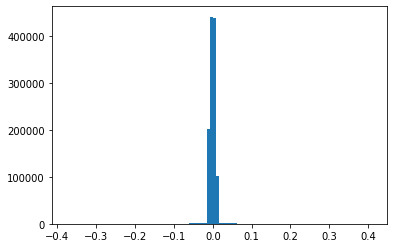

In [32]:
model.load_state_dict(torch.load("mnist_cnn2.pt"))
model = model.to(device)
model.eval()
full_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=ll_batch_size)
full_train_loader = [[data.to(device), target.to(device)] for data, target in full_train_loader]
original_parameters = parameters_to_vector(model.parameters()).detach().cpu().clone()
plt.hist(original_parameters.numpy(), bins=100)
len(original_parameters)

In [33]:
def plot_2d(df, val1, val2, ax, k1, k2, reference_ll):
    cmap = 'terrain'
    logp = df[:,2]
    p = np.exp(logp - reference_ll)
    length = np.sqrt(len(p))
    assert int(length) == length
    length = int(length)
    Y = df[:,0].reshape(length, length)
    X = df[:,1].reshape(length, length)
    
    ax.contourf(X, Y, p.reshape(length, length), levels=np.linspace(0,2,21), cmap=cmap)
    ax.axvline(x=val2, c='orchid', alpha=0.95)
    ax.axhline(y=val1, c='orchid', alpha=0.95)
    plt.title(f"{k1}-{v1}:{k2}-{v2}")
    
def plot_1d(df, val, train_limit, ax, k1, v1, reference_ll, plot=False):
    good = df[:,2].astype('float') / train_limit
    logp = df[:,1]
#     print("logp:", logp, reference_ll)
    p = np.exp(logp - reference_ll)
    p_N = fit_N(df[:,0], p)
    if plot:
        ax.plot(df[:,0], p);
        ax.axvline(x=val, c='r')
        ax.axhline(y=1, c='violet')
        ax.plot(df[:,0], p_N, alpha=0.7);
        ax.plot(df[:,0], good, alpha=0.7);
#         plt.ylim(0, 1.1)
        plt.title(f"i:{k1}, val: {v1}")
    return df[:,0], p


In [34]:
layers_shapes = {k: v.shape for k, v in model.state_dict().items()}
layers = list(layers_shapes.keys())
sampled_indices1 = {layer: draw_weight(layers_shapes[layer], 1) for layer in layers}
sampled_indices2 = {layer: draw_weight(layers_shapes[layer], 1) for layer in layers}

........


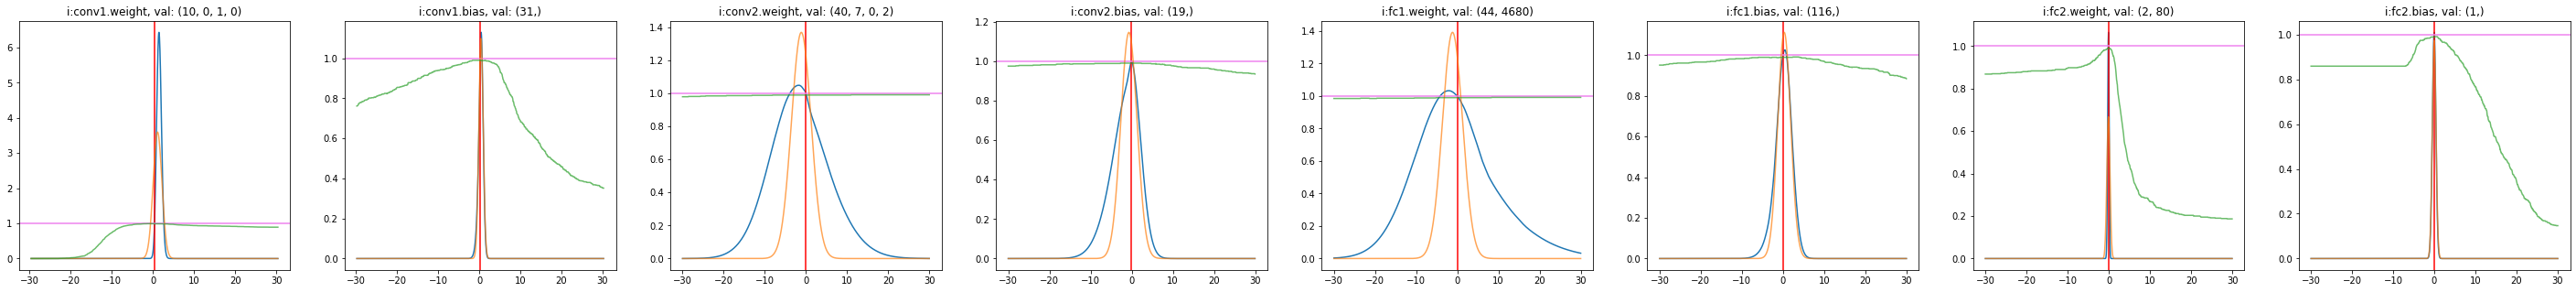

........


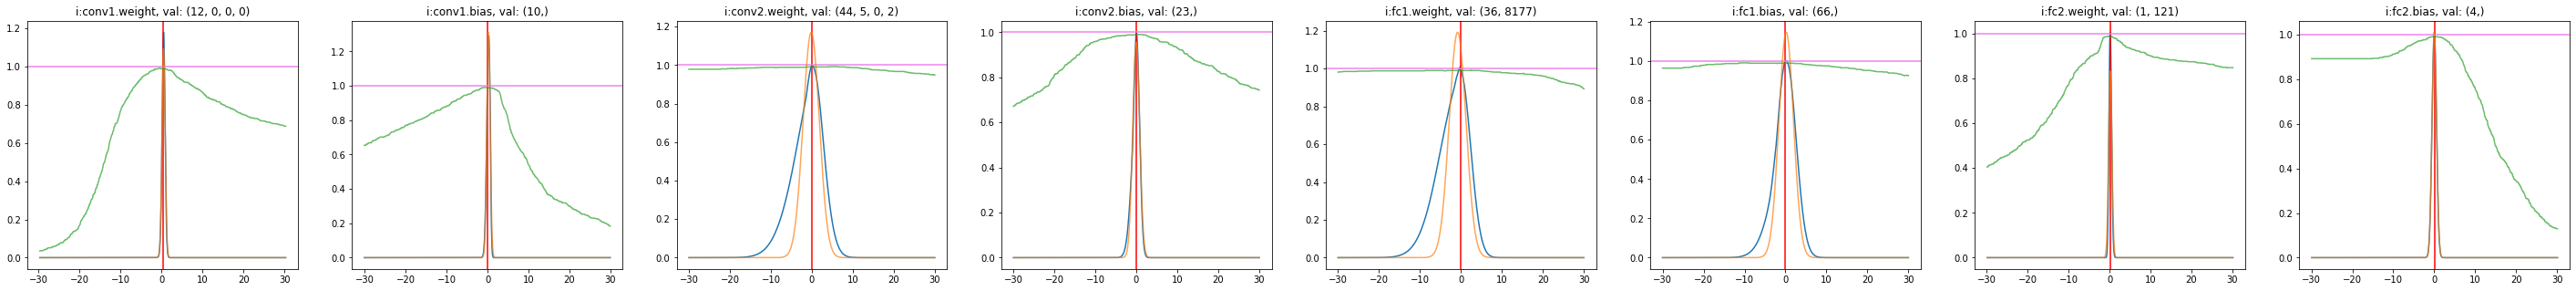

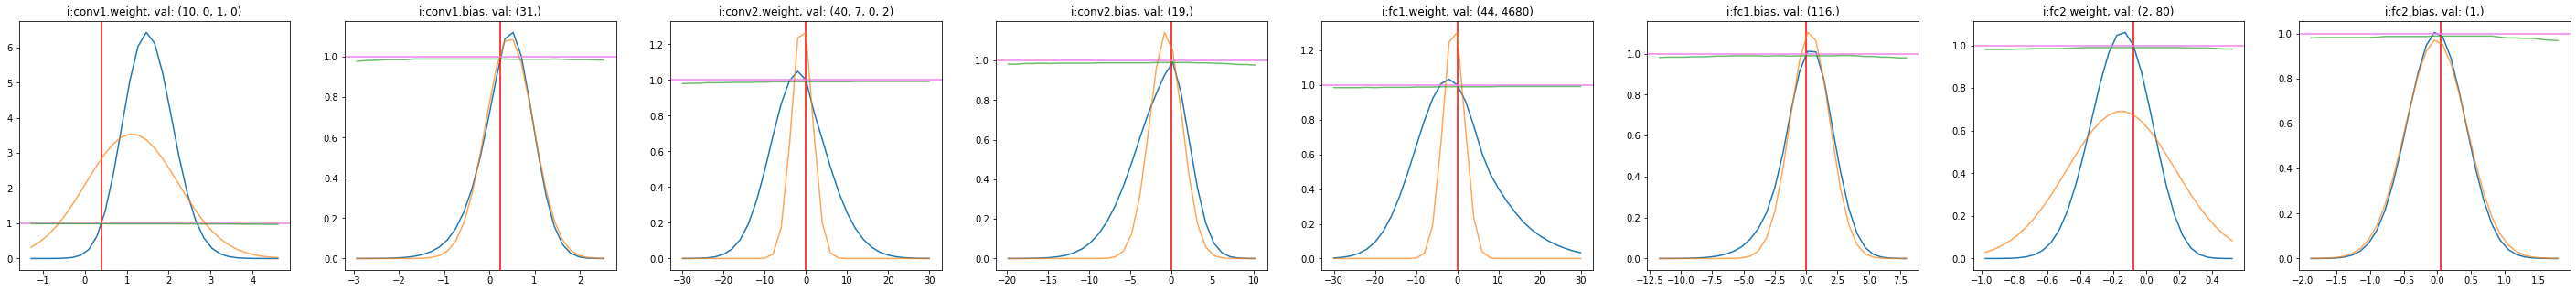

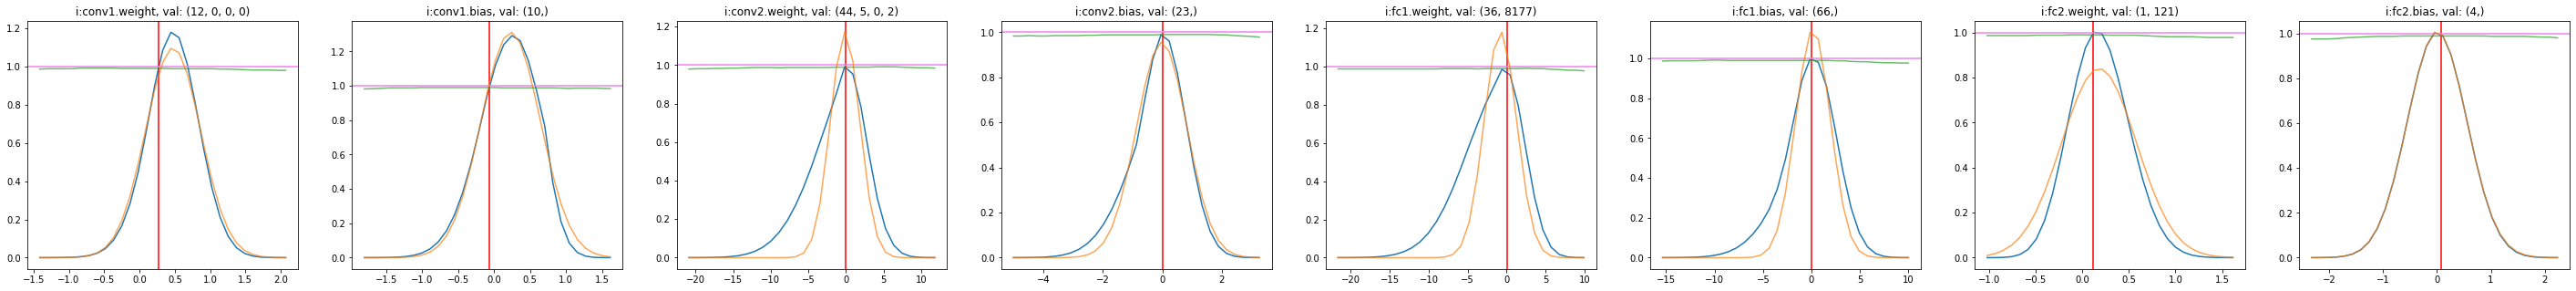

ROW: conv1.weight (10, 0, 1, 0)
ROW: conv1.bias (31,)
ROW: conv2.weight (40, 7, 0, 2)
ROW: conv2.bias (19,)
ROW: fc1.weight (44, 4680)
ROW: fc1.bias (116,)
ROW: fc2.weight (2, 80)
ROW: fc2.bias (1,)


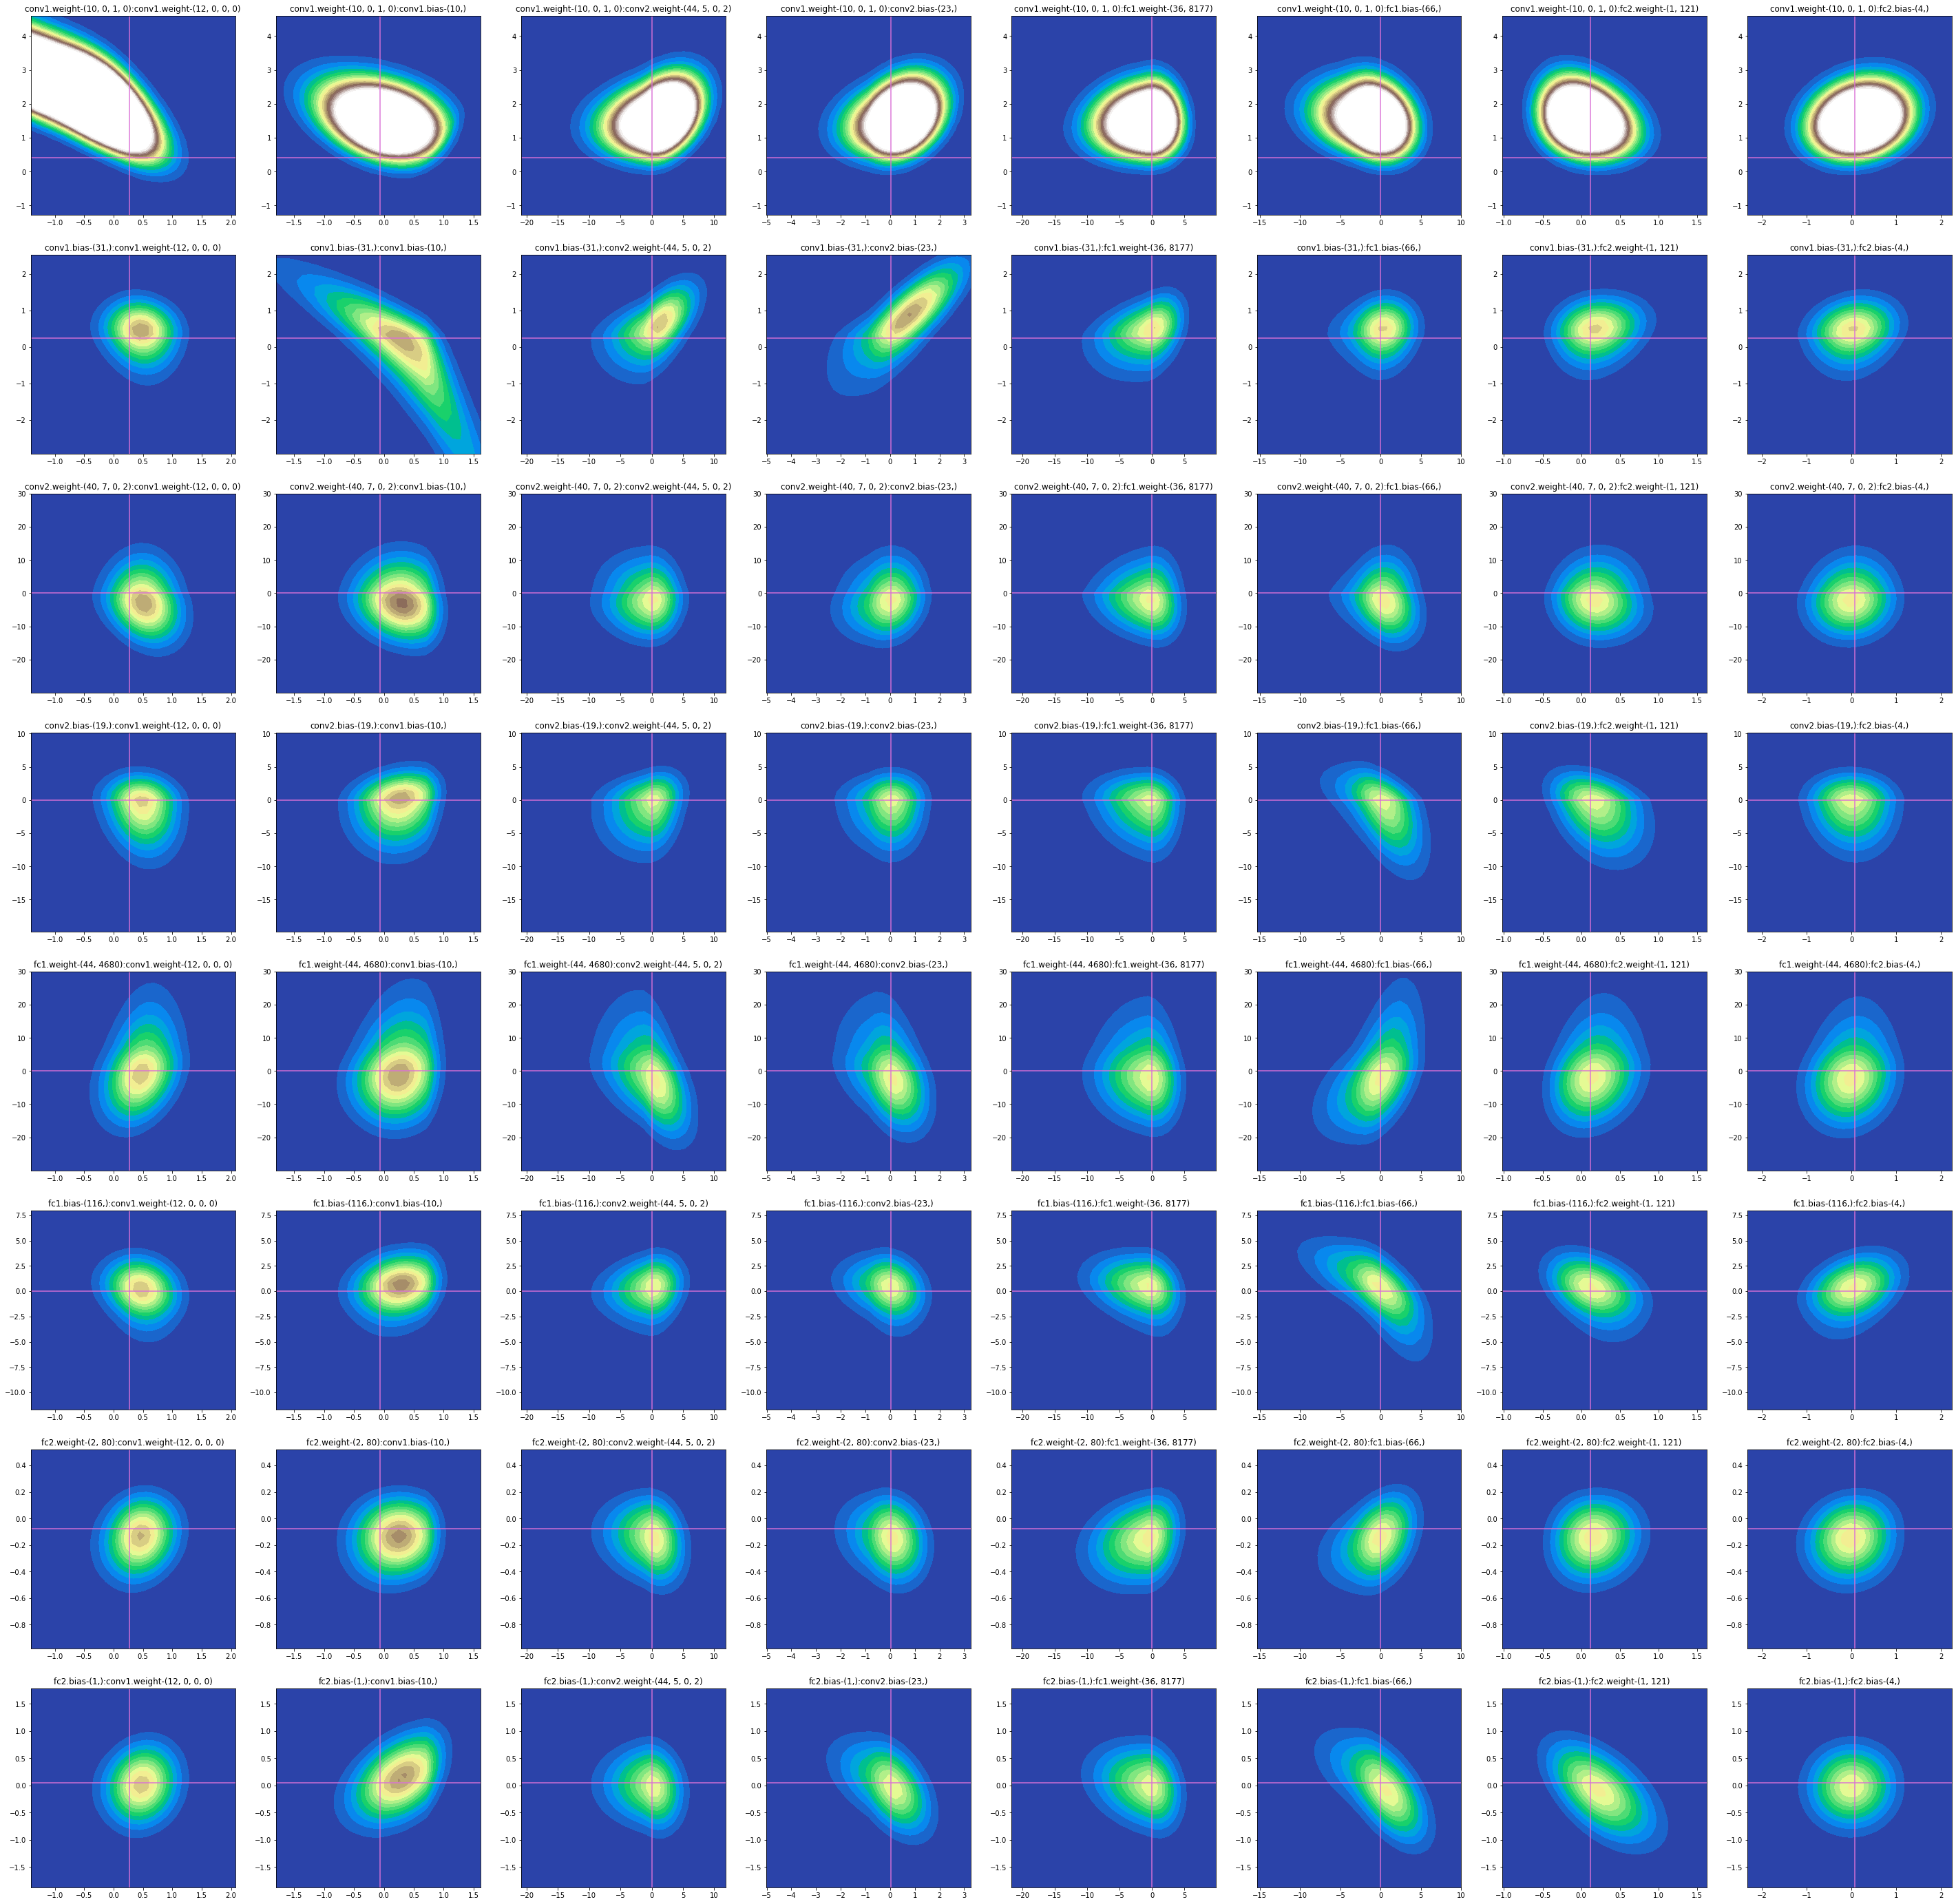

In [35]:
window = 30
search_rate = 1000
rate = 30

vector_to_parameters(original_parameters, model.parameters())
model.to(device)
model.eval()
reference_ll, _ = calculate_ll(full_train_loader, model)

weight_ranges = dict()
plt.figure(figsize=(50, 5))


for idx1, (k1, v1) in enumerate(sampled_indices1.items(), 1):
    ncol = len(sampled_indices1)
    print(".", end='')
    ax = plt.subplot(1, ncol, idx1)
    val1 = model.state_dict()[k1][v1].item()
    df = []
    for value1 in np.linspace(val1 - window, val1 + window, search_rate+1):
        model.state_dict()[k1][v1] = value1
        ll, good = calculate_ll(full_train_loader, model)
        df.append((value1, ll, good))
    df = np.array(df)
    val_vector, p_vector = plot_1d(df, val1, train_limit, ax, k1, v1, reference_ll, plot=True)
    valid_values = p_vector > 1e-4
    valid_inds = np.arange(len(valid_values))[valid_values]
    ind_min, ind_max = np.max([0, valid_inds.min()-1]), np.min([valid_inds.max() + 1, len(val_vector) - 1])
    weight_ranges[(k1, v1)] = (val_vector[ind_min], val_vector[ind_max])
#     print(p_vector)
#     print(valid_inds)
#     print(weight_ranges[(k1, v1)])
    model.state_dict()[k1][v1] = val1
print()
plt.show()
plt.figure(figsize=(50, 5))
for idx1, (k1, v1) in enumerate(sampled_indices2.items(), 1):
    ncol = len(sampled_indices1)
    print(".", end='')
    ax = plt.subplot(1, ncol, idx1)
    val1 = model.state_dict()[k1][v1].item()
    df = []
    for value1 in np.linspace(val1 - window, val1 + window, search_rate+1):
        model.state_dict()[k1][v1] = value1
        ll, good = calculate_ll(full_train_loader, model)
        df.append((value1, ll, good))
    df = np.array(df)
    val_vector, p_vector = plot_1d(df, val1, train_limit, ax, k1, v1, reference_ll, plot=True)
    valid_values = p_vector > 1e-4
    valid_inds = np.arange(len(valid_values))[valid_values]
    ind_min, ind_max = (np.max([0, valid_inds.min()-1]), np.min([valid_inds.max() + 1, len(val_vector) - 1]))
    weight_ranges[(k1, v1)] = (val_vector[ind_min], val_vector[ind_max])
#     print(p_vector)
#     print(valid_inds)
#     print(weight_ranges[(k1, v1)])
    model.state_dict()[k1][v1] = val1
print()
plt.show()

plt.figure(figsize=(50, 5))
for idx1, (k1, v1) in enumerate(sampled_indices1.items(), 1):
    ncol = len(sampled_indices1)
    ax = plt.subplot(1, ncol, idx1)
    val1 = model.state_dict()[k1][v1].item()
    df = []
    val_min, val_max = weight_ranges[(k1, v1)]
    for value1 in np.linspace(val_min, val_max, rate+1):
        model.state_dict()[k1][v1] = value1
        ll, good = calculate_ll(full_train_loader, model)
        df.append((value1, ll, good))
    df = np.array(df)
    plot_1d(df, val1, train_limit, ax, k1, v1, reference_ll, plot=True)
    model.state_dict()[k1][v1] = val1
plt.show()
plt.figure(figsize=(50, 5))
for idx1, (k1, v1) in enumerate(sampled_indices2.items(), 1):
    ncol = len(sampled_indices1)
    ax = plt.subplot(1, ncol, idx1)
    val1 = model.state_dict()[k1][v1].item()
    df = []
    val_min, val_max = weight_ranges[(k1, v1)]
    for value1 in np.linspace(val_min, val_max, rate+1):
        model.state_dict()[k1][v1] = value1
        ll, good = calculate_ll(full_train_loader, model)
        df.append((value1, ll, good))
    df = np.array(df)
    plot_1d(df, val1, train_limit, ax, k1, v1, reference_ll, plot=True)
    model.state_dict()[k1][v1] = val1
plt.show()

plt.figure(figsize=(50, 50))
for idx1, (k1, v1) in enumerate(sampled_indices1.items(), 0):
    ncol = len(sampled_indices1)
    print("ROW:",k1, v1)
    for idx2, (k2, v2) in enumerate(sampled_indices2.items(), 1):
        ax = plt.subplot(ncol, ncol, ncol * idx1 + idx2)
        val1 = model.state_dict()[k1][v1].item()
        val2 = model.state_dict()[k2][v2].item()
#         print("COL:", k2, v2)
        df = []
        val_min1, val_max1 = weight_ranges[(k1, v1)]
        val_min2, val_max2 = weight_ranges[(k2, v2)]
        if (k1, v1) == (k2, v2):
            continue
        for value1 in np.linspace(val_min1, val_max1, rate + 1):
            for value2 in np.linspace(val_min2, val_max2, rate + 1):
                model.state_dict()[k1][v1] = value1
                model.state_dict()[k2][v2] = value2
                ll, good = calculate_ll(full_train_loader, model)
                df.append((value1, value2, ll, good))
        df = np.array(df)
        plot_2d(df, val1, val2, ax, k1, k2, reference_ll)
        model.state_dict()[k1][v1] = val1
        model.state_dict()[k2][v2] = val2
plt.show()
